In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM
from tensorflow.keras.activations import relu
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences 

import warnings
warnings.filterwarnings(action = 'ignore')

In [72]:
df = pd.read_csv('../Data/spam.csv', encoding= 'latin-1')

In [73]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [74]:
df.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [75]:
df.shape

(5572, 5)

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [77]:
df[~df['Unnamed: 2'].isnull()]['Unnamed: 2']

95                                            PO Box 5249
281      the person is definitely special for u..... B...
444      HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE ...
671      wanted to say hi. HI!!!\" Stop? Send STOP to ...
710       this wont even start........ Datz confidence.."
899                                           PO Box 5249
1038                                                   GN
1127                                             .;-):-D"
1266    just been in bedbut mite go 2 thepub l8tr if u...
1384     bt not his girlfrnd... G o o d n i g h t . . .@"
1428                                        I'll come up"
1559     don't miss ur best life for anything... Gud n...
1637     just as a shop has to give a guarantee on wha...
1669     But at d end my love compromised me for every...
1675     the toughest is acting Happy with all unspoke...
1936                                  smoke hella weed\""
1937                       \" not \"what i need to do.\""
1997    JUST G

In [78]:
df[~df['Unnamed: 2'].isnull()]['v2'] 

95      Your free ringtone is waiting to be collected....
281                                   \Wen u miss someone
444     \HEY HEY WERETHE MONKEESPEOPLE SAY WE MONKEYAR...
671            SMS. ac sun0819 posts HELLO:\You seem cool
710     Height of Confidence: All the Aeronautics prof...
899     Your free ringtone is waiting to be collected....
1038    Edison has rightly said, \A fool can ask more ...
1127    Height of \Oh shit....!!\" situation: A guy th...
1266      \Hey sorry I didntgive ya a a bellearlier hunny
1384    Storming msg: Wen u lift d phne, u say \HELLO\...
1428    Tell you what, if you make a little spreadshee...
1559    Single line with a big meaning::::: \Miss anyt...
1637    0A$NETWORKS allow companies to bill for SMS, s...
1669    Very hurting n meaningful lines ever: \I compr...
1675    Painful words- \I thought being Happy was the ...
1936        My planning usually stops at \find hella weed
1937    The fact that you're cleaning shows you know w...
1997          

In [79]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [80]:
df['v2'] = np.where((df['Unnamed: 2'].isnull()), df['v2'], (df['v2'] + ' ' + df['Unnamed: 2']))

In [81]:
df['v2'] = np.where((df['Unnamed: 3'].isnull()), df['v2'], (df['v2'] + ' ' + df['Unnamed: 3']))

In [82]:
df['v2'] = np.where((df['Unnamed: 4'].isnull()), df['v2'], (df['v2'] + ' ' + df['Unnamed: 4']))

In [83]:
df.iloc[95, 1]

'Your free ringtone is waiting to be collected. Simply text the password \\MIX\\" to 85069 to verify. Get Usher and Britney. FML  PO Box 5249  MK17 92H. 450Ppw 16"'

In [84]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [85]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace= True, axis = 1)

In [86]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

In [87]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

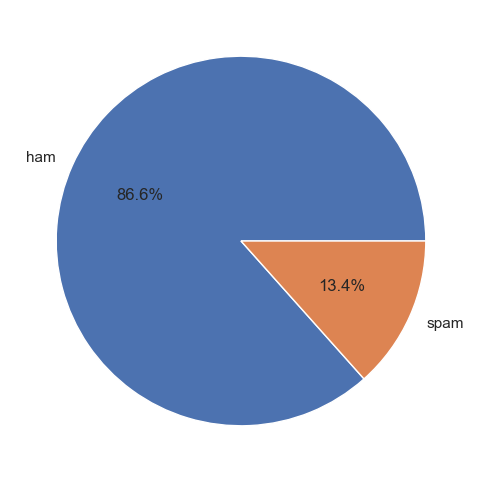

In [88]:
sns.set()
plt.figure(figsize = (6, 6))
plt.pie(x = (df['v1'].value_counts().values), labels= (df['v1'].value_counts().keys()), autopct= '%1.1f%%')
plt.show()

In [89]:
df['v1'] = np.where((df['v1'] == 'ham'), 0, 1)

df['v1'].value_counts()

0    4825
1     747
Name: v1, dtype: int64

In [90]:
X = df['v2']
y = df['v1']

In [91]:
X

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: v2, Length: 5572, dtype: object

In [92]:
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: v1, Length: 5572, dtype: int32

In [93]:
X.shape

(5572,)

In [94]:
y.shape

(5572,)

In [95]:
X = X.values.flatten()

In [96]:
X[1]

'Ok lar... Joking wif u oni...'

In [97]:
print(list( stopwords.words('english')))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [98]:
ps = PorterStemmer()

corpus = []

for i in range(0, len(X)):
    text = re.sub('f[a-zA-Z]', ' ', X[i])
    text = text.lower()
    text = text.split()
    
    text = [ps.stem(j) for j in text if not j in stopwords.words('english')]
    text = ' '.join(text)
    corpus.append(text)
    print(f"Status : {i}")

Status : 0
Status : 1
Status : 2
Status : 3
Status : 4
Status : 5
Status : 6
Status : 7
Status : 8
Status : 9
Status : 10
Status : 11
Status : 12
Status : 13
Status : 14
Status : 15
Status : 16
Status : 17
Status : 18
Status : 19
Status : 20
Status : 21
Status : 22
Status : 23
Status : 24
Status : 25
Status : 26
Status : 27
Status : 28
Status : 29
Status : 30
Status : 31
Status : 32
Status : 33
Status : 34
Status : 35
Status : 36
Status : 37
Status : 38
Status : 39
Status : 40
Status : 41
Status : 42
Status : 43
Status : 44
Status : 45
Status : 46
Status : 47
Status : 48
Status : 49
Status : 50
Status : 51
Status : 52
Status : 53
Status : 54
Status : 55
Status : 56
Status : 57
Status : 58
Status : 59
Status : 60
Status : 61
Status : 62
Status : 63
Status : 64
Status : 65
Status : 66
Status : 67
Status : 68
Status : 69
Status : 70
Status : 71
Status : 72
Status : 73
Status : 74
Status : 75
Status : 76
Status : 77
Status : 78
Status : 79
Status : 80
Status : 81
Status : 82
Status : 83
St

Status : 681
Status : 682
Status : 683
Status : 684
Status : 685
Status : 686
Status : 687
Status : 688
Status : 689
Status : 690
Status : 691
Status : 692
Status : 693
Status : 694
Status : 695
Status : 696
Status : 697
Status : 698
Status : 699
Status : 700
Status : 701
Status : 702
Status : 703
Status : 704
Status : 705
Status : 706
Status : 707
Status : 708
Status : 709
Status : 710
Status : 711
Status : 712
Status : 713
Status : 714
Status : 715
Status : 716
Status : 717
Status : 718
Status : 719
Status : 720
Status : 721
Status : 722
Status : 723
Status : 724
Status : 725
Status : 726
Status : 727
Status : 728
Status : 729
Status : 730
Status : 731
Status : 732
Status : 733
Status : 734
Status : 735
Status : 736
Status : 737
Status : 738
Status : 739
Status : 740
Status : 741
Status : 742
Status : 743
Status : 744
Status : 745
Status : 746
Status : 747
Status : 748
Status : 749
Status : 750
Status : 751
Status : 752
Status : 753
Status : 754
Status : 755
Status : 756
Status : 757

Status : 1292
Status : 1293
Status : 1294
Status : 1295
Status : 1296
Status : 1297
Status : 1298
Status : 1299
Status : 1300
Status : 1301
Status : 1302
Status : 1303
Status : 1304
Status : 1305
Status : 1306
Status : 1307
Status : 1308
Status : 1309
Status : 1310
Status : 1311
Status : 1312
Status : 1313
Status : 1314
Status : 1315
Status : 1316
Status : 1317
Status : 1318
Status : 1319
Status : 1320
Status : 1321
Status : 1322
Status : 1323
Status : 1324
Status : 1325
Status : 1326
Status : 1327
Status : 1328
Status : 1329
Status : 1330
Status : 1331
Status : 1332
Status : 1333
Status : 1334
Status : 1335
Status : 1336
Status : 1337
Status : 1338
Status : 1339
Status : 1340
Status : 1341
Status : 1342
Status : 1343
Status : 1344
Status : 1345
Status : 1346
Status : 1347
Status : 1348
Status : 1349
Status : 1350
Status : 1351
Status : 1352
Status : 1353
Status : 1354
Status : 1355
Status : 1356
Status : 1357
Status : 1358
Status : 1359
Status : 1360
Status : 1361
Status : 1362
Status

Status : 1900
Status : 1901
Status : 1902
Status : 1903
Status : 1904
Status : 1905
Status : 1906
Status : 1907
Status : 1908
Status : 1909
Status : 1910
Status : 1911
Status : 1912
Status : 1913
Status : 1914
Status : 1915
Status : 1916
Status : 1917
Status : 1918
Status : 1919
Status : 1920
Status : 1921
Status : 1922
Status : 1923
Status : 1924
Status : 1925
Status : 1926
Status : 1927
Status : 1928
Status : 1929
Status : 1930
Status : 1931
Status : 1932
Status : 1933
Status : 1934
Status : 1935
Status : 1936
Status : 1937
Status : 1938
Status : 1939
Status : 1940
Status : 1941
Status : 1942
Status : 1943
Status : 1944
Status : 1945
Status : 1946
Status : 1947
Status : 1948
Status : 1949
Status : 1950
Status : 1951
Status : 1952
Status : 1953
Status : 1954
Status : 1955
Status : 1956
Status : 1957
Status : 1958
Status : 1959
Status : 1960
Status : 1961
Status : 1962
Status : 1963
Status : 1964
Status : 1965
Status : 1966
Status : 1967
Status : 1968
Status : 1969
Status : 1970
Status

Status : 2544
Status : 2545
Status : 2546
Status : 2547
Status : 2548
Status : 2549
Status : 2550
Status : 2551
Status : 2552
Status : 2553
Status : 2554
Status : 2555
Status : 2556
Status : 2557
Status : 2558
Status : 2559
Status : 2560
Status : 2561
Status : 2562
Status : 2563
Status : 2564
Status : 2565
Status : 2566
Status : 2567
Status : 2568
Status : 2569
Status : 2570
Status : 2571
Status : 2572
Status : 2573
Status : 2574
Status : 2575
Status : 2576
Status : 2577
Status : 2578
Status : 2579
Status : 2580
Status : 2581
Status : 2582
Status : 2583
Status : 2584
Status : 2585
Status : 2586
Status : 2587
Status : 2588
Status : 2589
Status : 2590
Status : 2591
Status : 2592
Status : 2593
Status : 2594
Status : 2595
Status : 2596
Status : 2597
Status : 2598
Status : 2599
Status : 2600
Status : 2601
Status : 2602
Status : 2603
Status : 2604
Status : 2605
Status : 2606
Status : 2607
Status : 2608
Status : 2609
Status : 2610
Status : 2611
Status : 2612
Status : 2613
Status : 2614
Status

Status : 3178
Status : 3179
Status : 3180
Status : 3181
Status : 3182
Status : 3183
Status : 3184
Status : 3185
Status : 3186
Status : 3187
Status : 3188
Status : 3189
Status : 3190
Status : 3191
Status : 3192
Status : 3193
Status : 3194
Status : 3195
Status : 3196
Status : 3197
Status : 3198
Status : 3199
Status : 3200
Status : 3201
Status : 3202
Status : 3203
Status : 3204
Status : 3205
Status : 3206
Status : 3207
Status : 3208
Status : 3209
Status : 3210
Status : 3211
Status : 3212
Status : 3213
Status : 3214
Status : 3215
Status : 3216
Status : 3217
Status : 3218
Status : 3219
Status : 3220
Status : 3221
Status : 3222
Status : 3223
Status : 3224
Status : 3225
Status : 3226
Status : 3227
Status : 3228
Status : 3229
Status : 3230
Status : 3231
Status : 3232
Status : 3233
Status : 3234
Status : 3235
Status : 3236
Status : 3237
Status : 3238
Status : 3239
Status : 3240
Status : 3241
Status : 3242
Status : 3243
Status : 3244
Status : 3245
Status : 3246
Status : 3247
Status : 3248
Status

Status : 3780
Status : 3781
Status : 3782
Status : 3783
Status : 3784
Status : 3785
Status : 3786
Status : 3787
Status : 3788
Status : 3789
Status : 3790
Status : 3791
Status : 3792
Status : 3793
Status : 3794
Status : 3795
Status : 3796
Status : 3797
Status : 3798
Status : 3799
Status : 3800
Status : 3801
Status : 3802
Status : 3803
Status : 3804
Status : 3805
Status : 3806
Status : 3807
Status : 3808
Status : 3809
Status : 3810
Status : 3811
Status : 3812
Status : 3813
Status : 3814
Status : 3815
Status : 3816
Status : 3817
Status : 3818
Status : 3819
Status : 3820
Status : 3821
Status : 3822
Status : 3823
Status : 3824
Status : 3825
Status : 3826
Status : 3827
Status : 3828
Status : 3829
Status : 3830
Status : 3831
Status : 3832
Status : 3833
Status : 3834
Status : 3835
Status : 3836
Status : 3837
Status : 3838
Status : 3839
Status : 3840
Status : 3841
Status : 3842
Status : 3843
Status : 3844
Status : 3845
Status : 3846
Status : 3847
Status : 3848
Status : 3849
Status : 3850
Status

Status : 4427
Status : 4428
Status : 4429
Status : 4430
Status : 4431
Status : 4432
Status : 4433
Status : 4434
Status : 4435
Status : 4436
Status : 4437
Status : 4438
Status : 4439
Status : 4440
Status : 4441
Status : 4442
Status : 4443
Status : 4444
Status : 4445
Status : 4446
Status : 4447
Status : 4448
Status : 4449
Status : 4450
Status : 4451
Status : 4452
Status : 4453
Status : 4454
Status : 4455
Status : 4456
Status : 4457
Status : 4458
Status : 4459
Status : 4460
Status : 4461
Status : 4462
Status : 4463
Status : 4464
Status : 4465
Status : 4466
Status : 4467
Status : 4468
Status : 4469
Status : 4470
Status : 4471
Status : 4472
Status : 4473
Status : 4474
Status : 4475
Status : 4476
Status : 4477
Status : 4478
Status : 4479
Status : 4480
Status : 4481
Status : 4482
Status : 4483
Status : 4484
Status : 4485
Status : 4486
Status : 4487
Status : 4488
Status : 4489
Status : 4490
Status : 4491
Status : 4492
Status : 4493
Status : 4494
Status : 4495
Status : 4496
Status : 4497
Status

Status : 5077
Status : 5078
Status : 5079
Status : 5080
Status : 5081
Status : 5082
Status : 5083
Status : 5084
Status : 5085
Status : 5086
Status : 5087
Status : 5088
Status : 5089
Status : 5090
Status : 5091
Status : 5092
Status : 5093
Status : 5094
Status : 5095
Status : 5096
Status : 5097
Status : 5098
Status : 5099
Status : 5100
Status : 5101
Status : 5102
Status : 5103
Status : 5104
Status : 5105
Status : 5106
Status : 5107
Status : 5108
Status : 5109
Status : 5110
Status : 5111
Status : 5112
Status : 5113
Status : 5114
Status : 5115
Status : 5116
Status : 5117
Status : 5118
Status : 5119
Status : 5120
Status : 5121
Status : 5122
Status : 5123
Status : 5124
Status : 5125
Status : 5126
Status : 5127
Status : 5128
Status : 5129
Status : 5130
Status : 5131
Status : 5132
Status : 5133
Status : 5134
Status : 5135
Status : 5136
Status : 5137
Status : 5138
Status : 5139
Status : 5140
Status : 5141
Status : 5142
Status : 5143
Status : 5144
Status : 5145
Status : 5146
Status : 5147
Status

In [99]:
corpus

['go jurong point, crazy.. avail bugi n great world la e bu et... cine got amor wat...',
 'ok lar... joke wif u oni...',
 "free entri 2 wkli comp win fa cup nal tkt 21st may 2005. text fa 87121 receiv entri question(std txt rate)t&c' appli 08452810075over18'",
 'u dun say earli hor... u c alreadi say...',
 'nah think goe usf, live around though',
 "freemsg hey darl 3 week' word back! i'd like n r still? tb ok! xxx std chg send, å£1.50 rcv",
 'even brother like speak me. treat like aid patent.',
 "per request 'mell mell (oru minnaminungint nurungu vettam)' set callertun r callers. press *9 copi iend callertun",
 'winner!! valu network custom select receivea å£900 prize reward! claim call 09061701461. claim code kl341. valid 12 hour only.',
 'mobil 11 month more? u r entitl updat latest colour mobil camera r free! call mobil updat co free 08002986030',
 "i'm gonna home soon want talk stu anymor tonight, k? i'v cri enough today.",
 'six chanc win cash! 100 20,000 pound txt> csh11 send 875

In [100]:
voc_size = 5000
one_hot_r = [one_hot(i, n = voc_size) for i in corpus]
one_hot_r

[[2998,
  2108,
  1696,
  1240,
  3581,
  1663,
  1052,
  1804,
  2707,
  3949,
  3025,
  4614,
  3145,
  1826,
  2213,
  2622,
  270],
 [4172, 2699, 3070, 3627, 2665, 1625],
 [262,
  786,
  73,
  2154,
  1370,
  3035,
  3238,
  887,
  366,
  893,
  2617,
  4016,
  1142,
  3102,
  3238,
  3277,
  3285,
  786,
  4189,
  3,
  2807,
  215,
  3133,
  1493,
  3967,
  3904],
 [2665, 4522, 2856, 535, 531, 2665, 1885, 2620, 2856],
 [1920, 749, 2402, 1626, 4241, 3914, 2276],
 [4359,
  182,
  462,
  3156,
  3030,
  1035,
  2087,
  4168,
  1705,
  1052,
  4836,
  1811,
  3312,
  4172,
  4077,
  3,
  695,
  1185,
  3410,
  1113,
  3278],
 [2809, 2921, 1705, 199, 772, 1467, 1705, 541, 1872],
 [2441,
  3550,
  3585,
  3606,
  4164,
  1151,
  2595,
  1356,
  3873,
  634,
  2017,
  4836,
  2281,
  4897,
  4923,
  4026,
  2714,
  2017],
 [3014,
  96,
  721,
  2093,
  1062,
  1344,
  1903,
  480,
  2110,
  3676,
  97,
  2438,
  3676,
  1375,
  2089,
  4158,
  3431,
  1131,
  3574],
 [2923,
  2323,
  390

In [101]:
max_len = 0
leng = []

for i in one_hot_r:
    leng.append(len(i))

max_len = max(leng)
max_len

104

In [102]:
out_size = len(y.unique())
out_size

2

In [103]:
text_seq = pad_sequences(sequences= one_hot_r, padding= 'pre', maxlen= max_len)
text_seq

array([[   0,    0,    0, ..., 2213, 2622,  270],
       [   0,    0,    0, ..., 3627, 2665, 1625],
       [   0,    0,    0, ..., 1493, 3967, 3904],
       ...,
       [   0,    0,    0, ..., 2092, 3351, 3915],
       [   0,    0,    0, ..., 4913, 4836, 2079],
       [   0,    0,    0, ..., 3025, 2887, 1296]])

In [104]:
X = np.array(text_seq)
y = np.array(y)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.8, random_state= 6, shuffle= True)

In [106]:
model = Sequential([
    Embedding(input_dim=voc_size, output_dim=50, input_length= max_len),
    LSTM(units= 128),
    Dense(units= out_size, activation= 'relu')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 104, 50)           250000    
                                                                 
 lstm_2 (LSTM)               (None, 128)               91648     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 341906 (1.30 MB)
Trainable params: 341906 (1.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [107]:
model.compile(optimizer= 'adam', 
             loss = binary_crossentropy,
             metrics= ['acc'])

In [109]:
model.fit(X_train, y_train, batch_size= 100, verbose= 1, epochs = 2, validation_split= 0.1)

Epoch 1/2
41/41 [==============================] - 6s 151ms/step - loss: 0.0162 - acc: 0.8360 - val_loss: 0.1595 - val_acc: 0.8206
Epoch 2/2
41/41 [==============================] - 6s 155ms/step - loss: 0.0190 - acc: 0.8489 - val_loss: 0.1584 - val_acc: 0.8206
